### RESUMEN EJECUTIVO (LO QUE DEBERÍA DECIR TU SLIDE)
# 🚀 Executive Summary  
## SpaceX Falcon 9 First Stage Landing Prediction

## 🎯 Business Problem

SpaceX reduces launch costs (~$62M vs ~$165M competitors) by reusing the Falcon 9 first stage.  
If we can predict whether the first stage will successfully land, we can estimate the real cost of a launch.

This capability is valuable for:
- Competitive bidding strategies
- Risk assessment
- Cost forecasting

---

## 📊 Dataset Overview

- 90 historical Falcon 9 launches
- 83 engineered features (after encoding)
- Target variable:
  - 1 → Landed successfully
  - 0 → Did not land

Data preprocessing steps:
- Feature engineering
- One-hot encoding of categorical variables
- Standardization (StandardScaler)
- Train/Test split (80% / 20%)

---

## 🤖 Models Evaluated

Four machine learning classification models were trained and optimized using **GridSearchCV (10-fold cross-validation)**:

| Model | Validation Accuracy | Test Accuracy |
|-------|---------------------|--------------|
| Logistic Regression | 84.64% | 83.33% |
| Support Vector Machine | 84.82% | 83.33% |
| Decision Tree | **88.57%** | 83.33% |
| K-Nearest Neighbors | 84.82% | 83.33% |

---

## 🏆 Key Findings

- All models achieved identical performance on unseen test data (**83.33% accuracy**).
- Decision Tree achieved the highest cross-validation accuracy (88.57%).
- Similar test performance suggests:
  - Strong signal in the dataset
  - Limited sample size (90 observations)
  - Low variance across models

---

## 🔎 Error Analysis

Confusion matrix results show:

- Most successful landings are correctly predicted.
- Main limitation: **False Positives**
  - Predicting successful landing when it actually fails.



### Importamos librerias

In [8]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime

import seaborn as sns

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

### Helpers

In [9]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])


# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])


In [10]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

### data collection and data wrangling methodology slides

In [11]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

response=requests.get(static_json_url)

response.status_code

data = pd.json_normalize(response.json())

# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

BoosterVersion

getBoosterVersion(data)

getLaunchSite(data)

getPayloadData(data)

getCoreData(data)

launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

data = pd.DataFrame(launch_dict)

data_falcon9 = data[data['BoosterVersion'] != 'Falcon 1']
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))



In [12]:
#Dealing with Missing Values
data_falcon9.isnull().sum()

# Calculate the mean value of PayloadMass column
payload_mean = data_falcon9['PayloadMass'].mean()
# Replace the np.nan values with its mean value
data_falcon9.loc[:,'PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, payload_mean)
#data_falcon9.loc[:,'PayloadMass'] = data_falcon9['PayloadMass'].fillna(payload_mean)

data_falcon9.to_csv('dataset_part_1.csv', index=False)

### Data Wrangling

In [28]:
df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")

In [29]:
df.isnull().sum() / len(df) * 100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [30]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [31]:
df['LaunchSite'].value_counts()

LaunchSite
CCAFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64

In [32]:
df['Orbit'].value_counts()

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
HEO       1
ES-L1     1
SO        1
GEO       1
Name: count, dtype: int64

In [34]:

# landing_outcomes = values on Outcome column
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

In [35]:
for i , outcome in enumerate (landing_outcomes.keys()):
    print(i, outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [36]:
bad_outcomes = set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [37]:
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in df['Outcome']]

In [38]:
df['Class'] = landing_class
df[['Class']].head(8)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


In [39]:
df['Class'].mean()

np.float64(0.6666666666666666)

### Exploratory Data Analysis Methodology

In [16]:
import matplotlib.pyplot as plt


In [17]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
df = pd.read_csv(url)

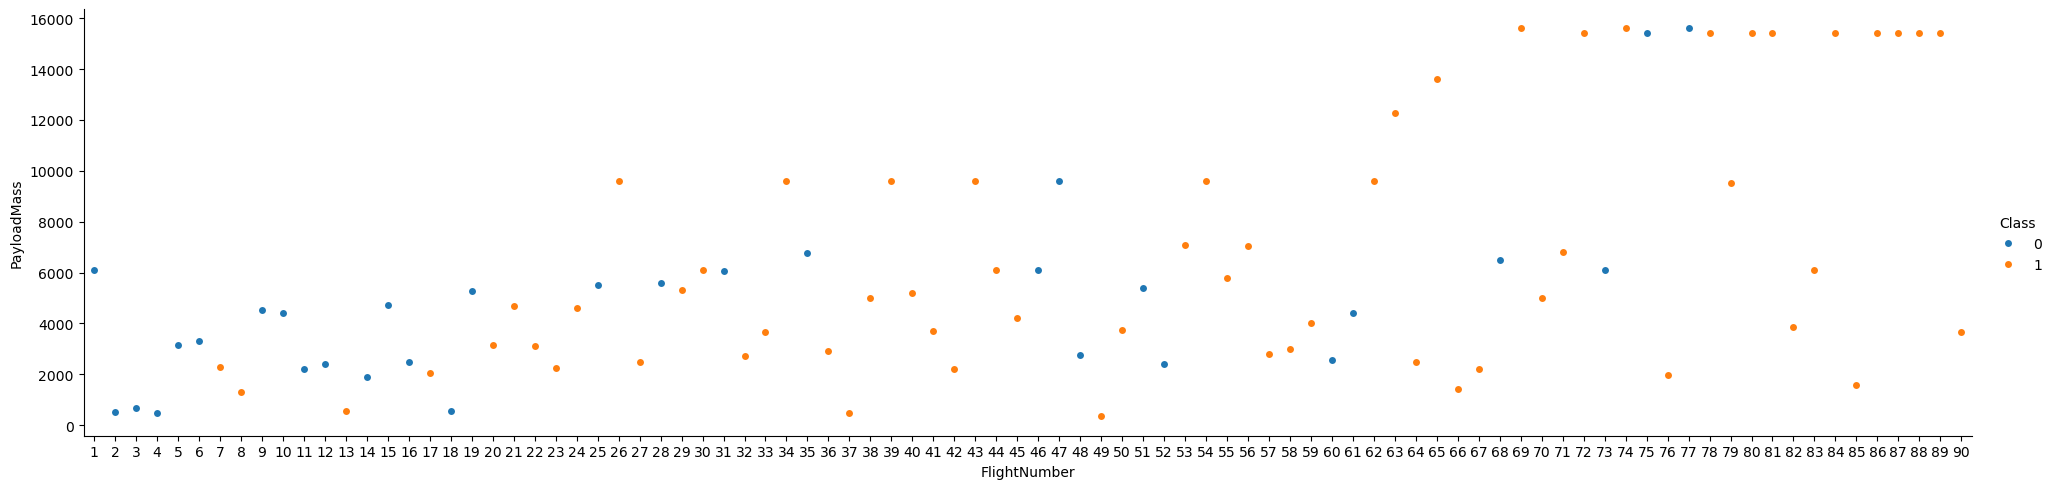

In [18]:
### Relationship btw flig number and lunch site
sns.catplot(y="PayloadMass", 
            x = 'FlightNumber',
            hue='Class',
            data=df,
            aspect=4)

plt.show()

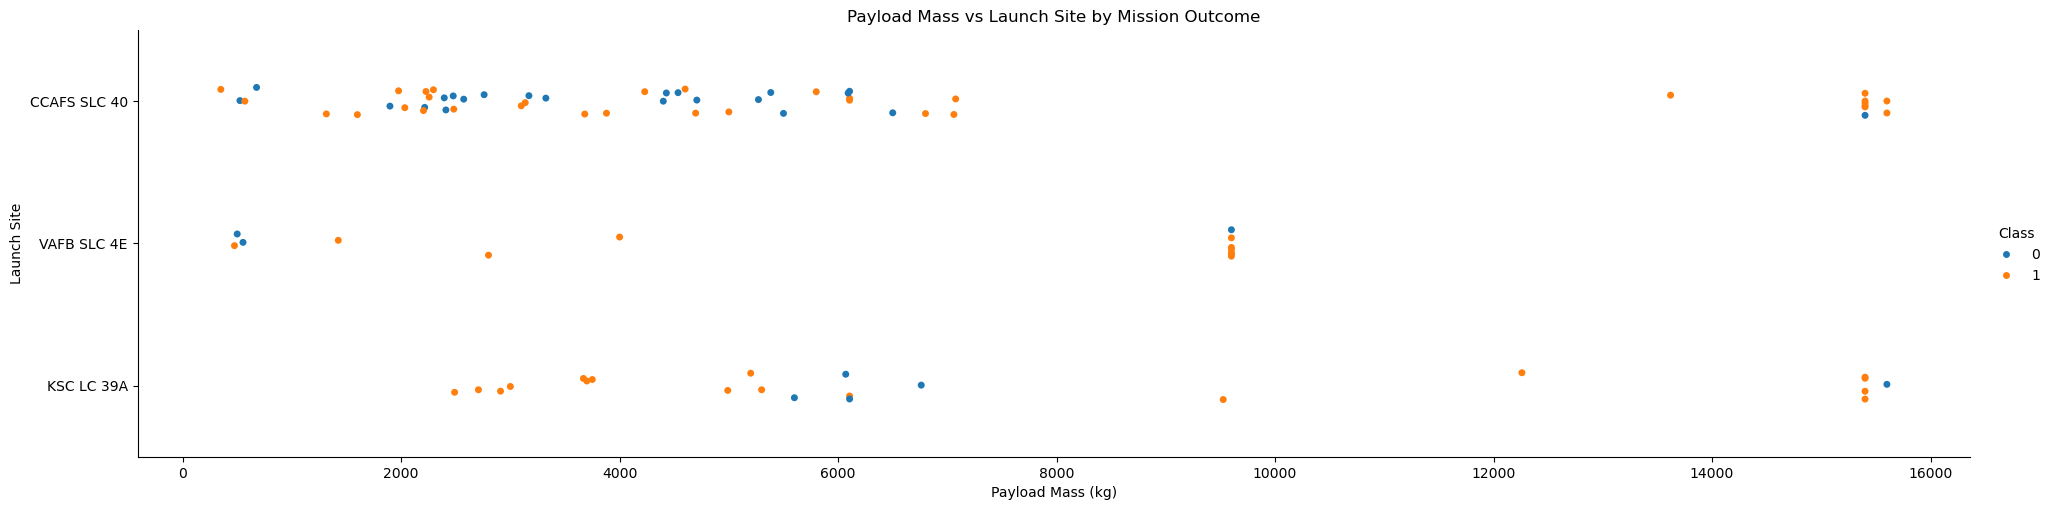

In [19]:
# Plot a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value

sns.catplot(x="PayloadMass",
                y="LaunchSite",
                hue='Class',
                data=df,
                aspect=4,
                kind="strip")

plt.xlabel("Payload Mass (kg)")
plt.ylabel("Launch Site")
plt.title("Payload Mass vs Launch Site by Mission Outcome")
plt.show()

Next, we want to visually check if there are any relationship between success rate and orbit type.


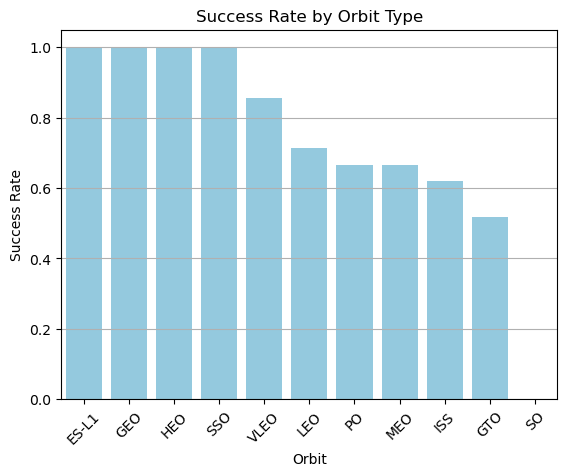

In [20]:
# HINT use groupby method on Orbit column and get the mean of Class column

# Calcular tasa de éxito por tipo de orbita
orbit_succes = df.groupby("Orbit")["Class"].mean().reset_index()

# Ordenar por tasa de éxito
orbit_succes = orbit_succes.sort_values(by="Class", ascending=False)

# Gráfico de barras
sns.barplot(data=orbit_succes, x="Orbit", y="Class", color="skyblue")

plt.ylabel("Success Rate")
plt.title("Success Rate by Orbit Type")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

The highest success rate has ES-L1, GEO, HEO, SSO

For each orbit, we want to see if there is any relationship between FlightNumber and Orbit type.


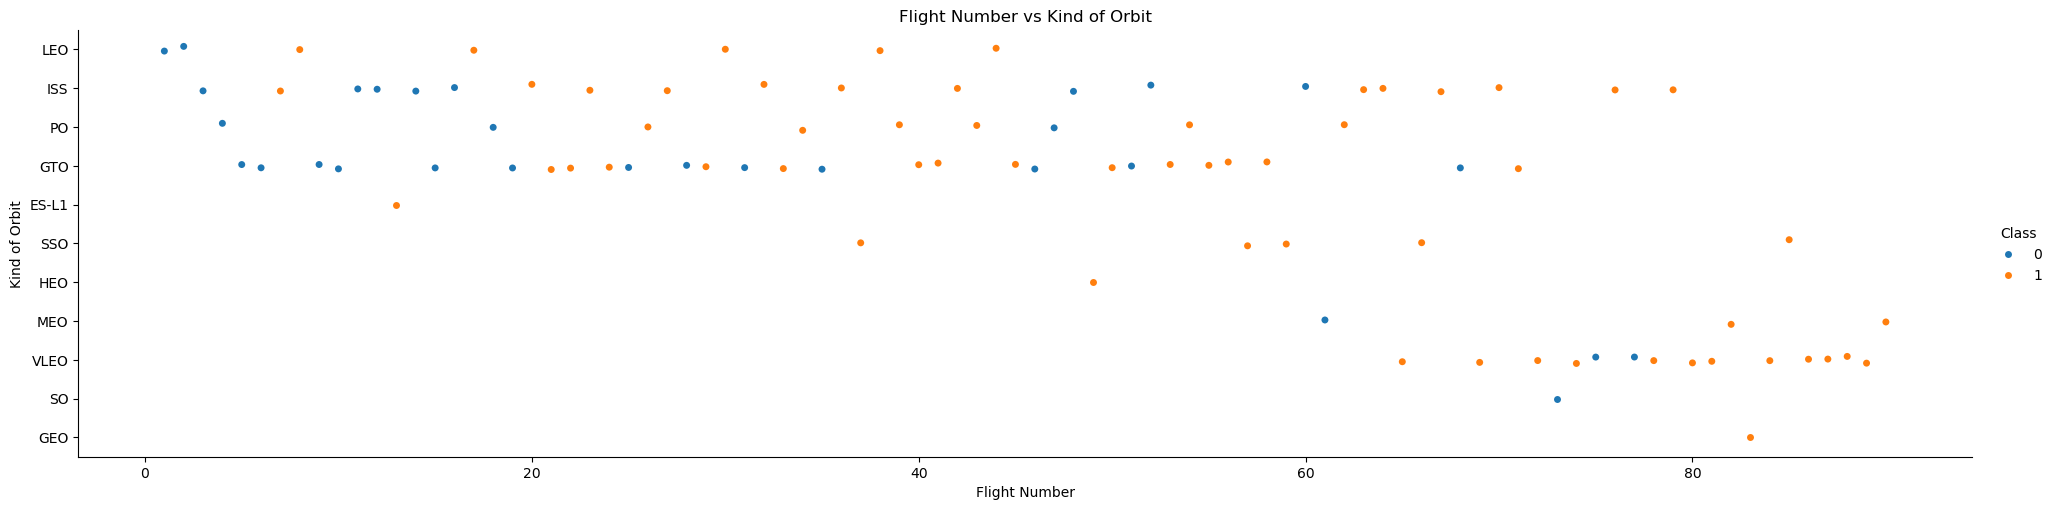

In [21]:
sns.catplot(x="FlightNumber",
            y="Orbit",
            hue="Class",
            data=df,
            aspect=4)
plt.xlabel("Flight Number")
plt.ylabel("Kind of Orbit")
plt.title("Flight Number vs Kind of Orbit")
plt.show()

Similarly, we can plot the Payload Mass vs. Orbit scatter point charts to reveal the relationship between Payload Mass and Orbit type

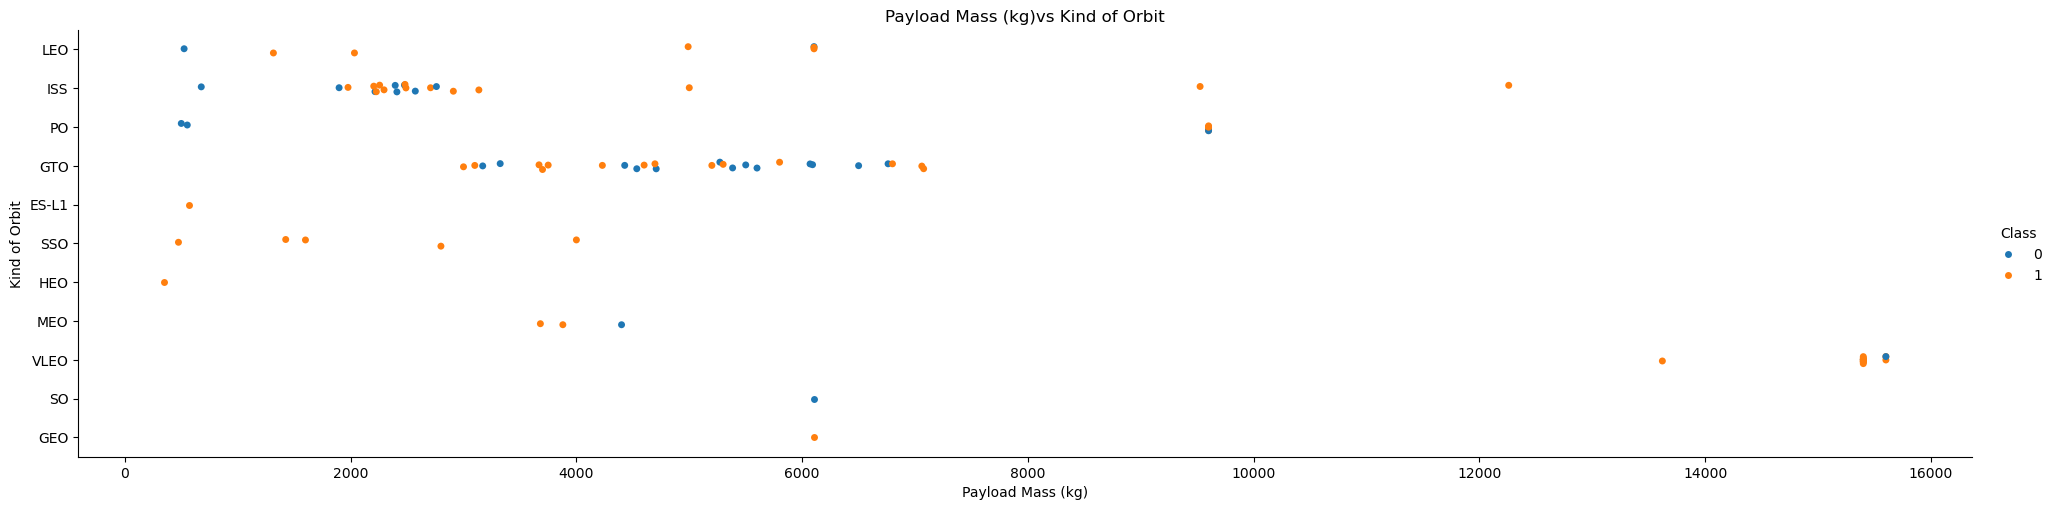

In [22]:
sns.catplot(x="PayloadMass",
            y="Orbit",
            hue="Class",
            data=df,
            aspect=4)
plt.xlabel("Payload Mass (kg)")
plt.ylabel("Kind of Orbit")
plt.title("Payload Mass (kg)vs Kind of Orbit")
plt.show()

With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.

However, for GTO, it's difficult to distinguish between successful and unsuccessful landings as both outcomes are present.


In [23]:
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
Extract_year()
df['Date'] = year
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


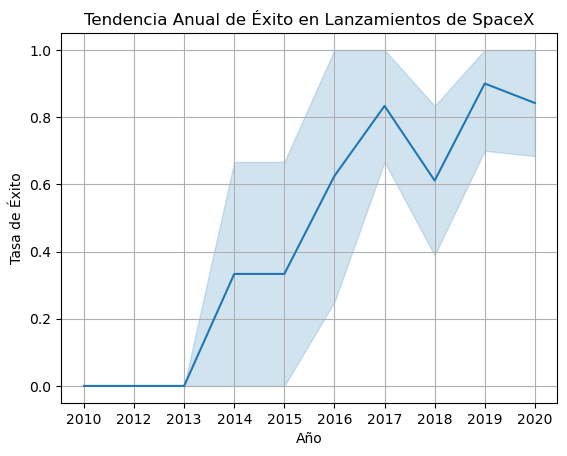

In [24]:

sns.lineplot(data=df,
             x="Date",
             y="Class",
             markers="o")

plt.title("Tendencia Anual de Éxito en Lanzamientos de SpaceX")
plt.ylabel("Tasa de Éxito")
plt.xlabel("Año")
plt.grid(True)
plt.xticks(df["Date"].unique())  # Asegura que cada año se vea
plt.show()

## Features Engineering


In [27]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]


# create dummy variable
features_one_hot = pd.get_dummies(features, columns=["Orbit", "LaunchSite", "LandingPad", "Serial"])

features_one_hot = features_one_hot.astype('float64')
features_one_hot.dtypes

features_one_hot.to_csv('dataset_part_3.csv', index=False)

features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6104.959412,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Machine Learning Prediction

In [40]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [41]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

In [42]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")

X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')

In [43]:
Y = df['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [44]:
transform = preprocessing.StandardScaler()

X = transform.fit_transform(X)

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
Y_test.shape

(18,)

In [52]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [54]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

logreg_cv = GridSearchCV(lr, parameters, cv=10)


#fit model
logreg_cv.fit(X_train, Y_train)


print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/home/antonio/.conda/envs/quantitative_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/antonio/.conda/envs/quantitative_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/antonio/.conda/envs/quantitative_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penal

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


/home/antonio/.conda/envs/quantitative_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/antonio/.conda/envs/quantitative_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/antonio/.conda/envs/quantitative_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penal

In [55]:

log_accuracy = logreg_cv.score(X_test, Y_test)

print("Test Accuracy: ", log_accuracy)

Test Accuracy:  0.8333333333333334


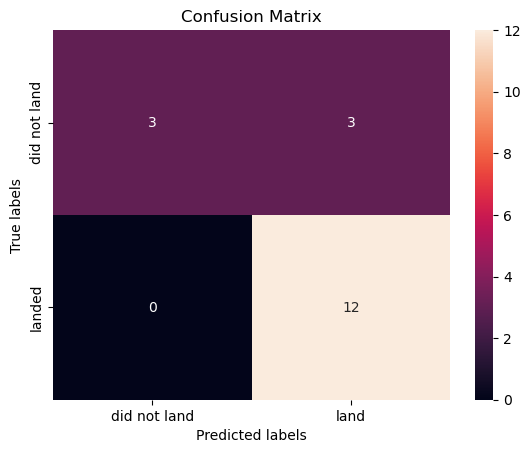

In [56]:

yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes. We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)

In [58]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()


svm_cv = GridSearchCV(svm, parameters, cv=10)

svm_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


In [59]:
svm_accuracy = svm_cv.score(X_test, Y_test)

print("Test Accuracy: ", svm_accuracy)

Test Accuracy:  0.8333333333333334


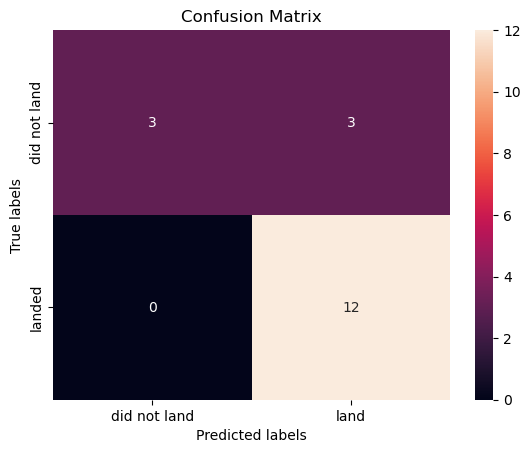

In [60]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [61]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],  # <-- sin 'auto'
     #'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

tree_cv = GridSearchCV(tree, parameters, cv=10)

tree_cv.fit(X_train, Y_train)


print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 18, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8857142857142858


In [62]:

tree_accuracy = tree_cv.score(X_test, Y_test)

print("Test Accuracy: ", tree_accuracy)

Test Accuracy:  0.8888888888888888


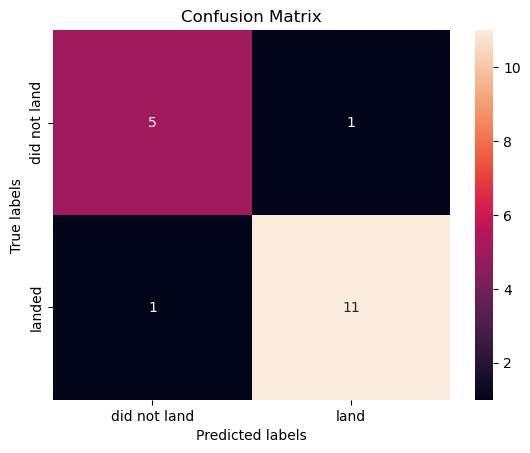

In [63]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [64]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(KNN, parameters, cv=10)

knn_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


In [65]:
KKn_accuracy = knn_cv.score(X_test, Y_test)

print("Test Accuracy: ", KKn_accuracy)

Test Accuracy:  0.8333333333333334


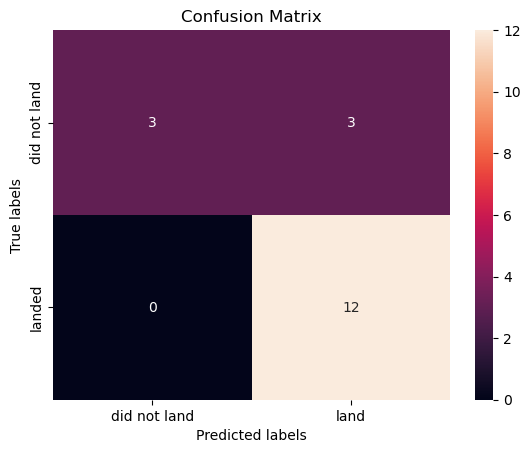

In [66]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [67]:
accuracy_scores = [log_accuracy, svm_accuracy, tree_accuracy, KKn_accuracy]

model_names = ['log_cv', 'svm_cv', 'tree_cv', 'knn_cv']

df = pd.DataFrame({'Model':model_names,
                   'Accuracy':accuracy_scores})
df

,Model,Accuracy
0,log_cv,0.833333
1,svm_cv,0.833333
2,tree_cv,0.888889
3,knn_cv,0.833333
